In [1]:
###General Code First Box
import pandas as pd
import numpy as np
import scanpy as sc
import magpy as mp
import scipy.stats as stats
import os
import math
import anndata as ad
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

def sort_list_by_pctexp(adata, gene_list, groupby='lineage'):
    subset = adata[:,gene_list]
    clusters = subset.obs[groupby].unique()
    pctexp = np.zeros((len(clusters),subset.shape[1]))
    for i,cluster in enumerate(clusters):
        subset2 = subset[subset.obs[groupby]==cluster]
        pctexp[i] = (subset2.layers['raw_normalized']>0).sum(axis=0).A1 / subset.shape[0]
    subset.var['pctmax'] = pctexp.max(axis=0)
    sorted_list = subset.var['pctmax'].sort_values(ascending=False).index.tolist()
    return sorted_list
def sort_list_by_mean(adata, gene_list, groupby='lineage'):
    subset = adata[:,gene_list]
    clusters = subset.obs[groupby].unique()
    cmeans = np.zeros((len(clusters),subset.shape[1]))
    for i,cluster in enumerate(clusters):
        subset2 = subset[subset.obs[groupby]==cluster]
        cmeans[i] = subset2.layers['raw_normalized'].mean(axis=0).A1
    subset.var['cmeans'] = cmeans.max(axis=0)
    sorted_list = subset.var['cmeans'].sort_values(ascending=False).index.tolist()
    return sorted_list
def means_to_df(adata, gene_list, save=None, groupby='lineage'):
    subset = adata[:,gene_list]
    clusters = subset.obs[groupby].unique()
    cmeans = {}
    for i,cluster in enumerate(clusters):
        subset2 = subset[subset.obs[groupby]==cluster]
        cmeans[cluster] = subset2.layers['raw_normalized'].mean(axis=0).A1
    df = pd.DataFrame(cmeans,index=gene_list)
    if save: df.to_csv(save)
    return df

combined_path = "/proj/magness/CDS010-014-015_combined/"
plt.rcParams ['figure.facecolor'] = 'white'

# sc.set_figure_params(dpi_save = 300, format = 'svg')
fig_path = combined_path+'fig1/'
sc.settings.figdir = fig_path
contrast_palette = ['#00ff7f','#b22222','#b8b8b8','#f0e68c','#705000','#00bfff','#dda0dd','#00ffff','#ccccff',
                    '#ff0000','#808000','#3cb371','#a97a67','#ff8c00','#ffd700','#02026e','#adff2f','#4169e1',
                    '#ffa07a','#2f4f4f','#7f007f','#6e6e6e','#ff00ff']

adata = mp.load(combined_path, "clustered_annotated_adata_k25_lr0.92_v1.5.h5ad")


Reading data from /proj/magness/CDS010-014-015_combined/clustered_annotated_adata_k25_lr0.92_v1.5.h5ad



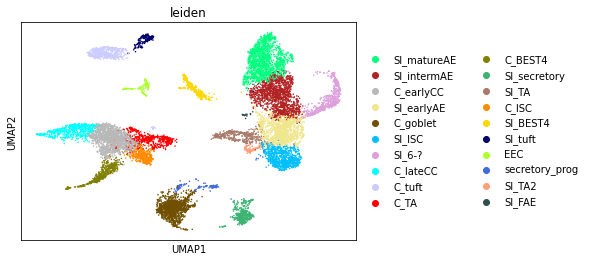

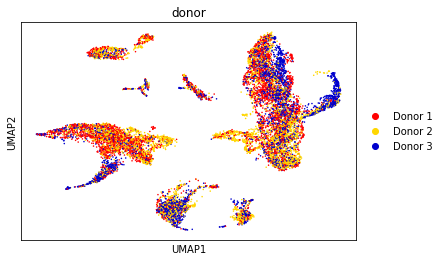

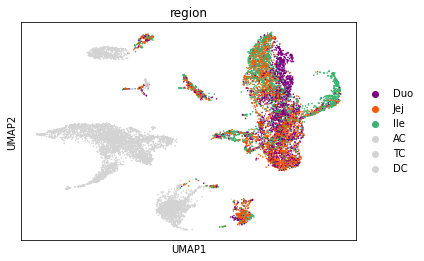

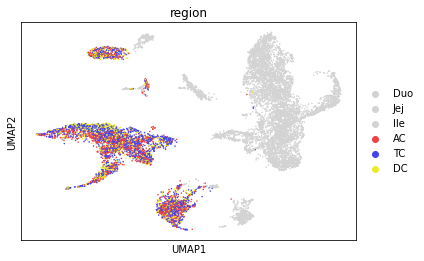

In [2]:
## UMAPS for figure 1

##Fig 1B
sc.pl.umap(adata, color = 'leiden', palette = contrast_palette)#, save = '_lineage_v3.0')

###Fig 1C
sc.pl.umap(adata, color = 'donor', palette = ['#ff0000','#ffd700','#0000cd'])#, save = '_donor_v3.0')
##Fig 1D,E
sc.pl.umap(adata, color = 'region', palette = ['#7f007f','#FF5700','#3cb371','#d3d3d3','#d3d3d3','#d3d3d3'])#, save = '_SI_regions_v3.0')
sc.pl.umap(adata, color = 'region', palette = ['#d3d3d3','#d3d3d3','#d3d3d3','#EF4344','#4344EF','#EDEC2C'])#, save = '_C_regions_v3.0')

### Alternative viewing for Figs 1D,E
# si_subset = adata[adata.obs['organ']=='SI']
# c_subset = adata[adata.obs['organ']=='Colon']
# sc.pl.umap(si_subset, color = 'region', palette = ['#7f007f','#FF5700','#3cb371'])
# sc.pl.umap(c_subset, color = 'region', palette = ['#003c89','#597cac','#9bbcd4'])

# sc.pl.umap(si_subset, color = 'region', palette = ['#c15013','#e57e2a','#edb078'])
# sc.pl.umap(c_subset, color = 'region', palette = ['#003c89','#597cac','#9bbcd4'])

Reading data from /proj/magness/CDS010-014-015_combined/clustered_annotated_adata_k25_lr0.92_v1.5.h5ad



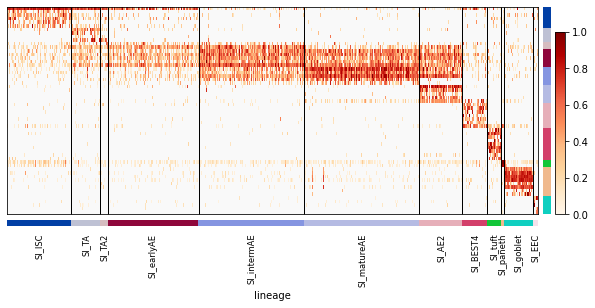

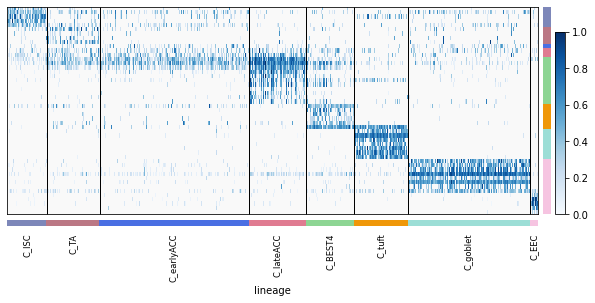

In [3]:
### Fig 1 F,G - SI and Colon HEATMAPS ###

expt_path = "/proj/magness/CDS010-014-015_combined"

adata = mp.load(expt_path, "clustered_annotated_adata_k25_lr0.92_v1.5.h5ad")
# sc.set_figure_params(dpi_save = 300, dpi = 200, format = 'svg')
sc.settings.figdir = expt_path+'/figures/Fig1_heatmaps'


si_list = {'Stem': ['OLFM4','LGR5', 'RGMB', 'ASCL2', 'SMOC2', 'ALDH1B1'], 
           'TA': ['TYMS', 'RAD51AP1', 'NCAPG2','MKI67'], 
           'EarlyAE': ['AKR1C1',  'GSTA1'], 
           'IntermAE': ['PCK2', 'ADIRF', 'KHK', 'PEPD', 'RBP2'], 
           'MatureAE': ['APOA4', 'CYP3A4', 'APOB', 'LCT', 'CD36'], 
           'unknown': ['FABP6','PLB1','CUBN','TMIGD1','GUCA2A'],
           'BEST4': ['NOTCH2', 'BEST4', 'MEIS1', 'RHOV', 'NBPF19', 'KRT72','LYZ'], 
           'Tuft': ['POU2F3','SH2D6','HTR3E','TAS1R3','HPGDS','RGS13','GNAT3','MELTF','GABRA4'],
           'Paneth':['DEFA5','DEFA6'],
           'Goblet': ['ITLN1','SPINK4','CLCA1','FCGBP','ATOH1','MUC2','FAM177B','ABCA4'], 
           'EEC': ['CHGA', 'PYY', 'GCG', 'SCGN', 'PCSK1']}


c_list = {'Stem': ['LGR5', 'RGMB', 'ASCL2', 'SMOC2', 'ALDH1B1'], 
           'TA': ['TYMS', 'RAD51AP1', 'NCAPG2','MKI67'], 
           'EarlyAE': ['B3GNT7'], 
           'IntermAE': ['PCK2', 'ADIRF'], 
           'MatureAE': ['SLC26A2','FABP1','CA2','SLC26A3','CA1','CEACAM1','CEACAM7','AQP8','MS4A12','SLC51B','DHRS9'], 
           'BEST4': ['NOTCH2', 'BEST4', 'MEIS1', 'RHOV', 'NBPF19','SPIB'], 
           'Tuft': ['POU2F3','SH2D6','HTR3E','TAS1R3','HPGDS','RGS13','AFAP1L2'], 
           'Goblet': ['ITLN1','SPINK4','CLCA1','FCGBP','ATOH1','MUC2','B3GNT6','WFDC2'], 
           'EEC': ['CHGA', 'PYY', 'GCG', 'SCGN', 'PCSK1']}


si_order = ['SI_ISC','SI_TA','SI_TA2','SI_earlyAE','SI_intermAE','SI_matureAE','SI_AE2',
            'SI_BEST4','SI_tuft','SI_paneth','SI_goblet','SI_EEC'] 
si_subset = adata[adata.obs['lineage'].isin(si_order)]
si_subset.obs.lineage.cat.reorder_categories(si_order,inplace=True)


# print([a for a in adata.obs.lineage.unique() if a.startswith('C_')])
c_order = ['C_ISC','C_TA','C_earlyACC','C_lateACC','C_BEST4','C_tuft','C_goblet','C_EEC']
c_subset = adata[adata.obs['lineage'].isin(c_order)]
c_subset.obs.lineage.cat.reorder_categories(c_order,inplace=True)


### PLOTTING ###
from matplotlib.colors import ListedColormap

OrRd = plt.get_cmap('OrRd')(np.linspace(0,1,256))
Blues = plt.get_cmap('Blues')(np.linspace(0,1,256))

OrRd[0] = np.array([0.98,0.98,0.98,1.0])
Blues[0] = np.array([0.98,0.98,0.98,1.0])

new_OrRd = ListedColormap(OrRd)
new_Blues = ListedColormap(Blues)

show_genes = False

sc.pl.heatmap(si_subset,si_list,
                 groupby='lineage',
                 swap_axes=True,
                 standard_scale='var',
                 show_gene_labels=show_genes,
                 cmap=new_OrRd,
             )#save="_SI-markers_v5_white_grey98.svg")

sc.pl.heatmap(c_subset,c_list,
                 groupby='lineage',
                 swap_axes=True,
                 standard_scale='var',
                 show_gene_labels=show_genes,
                 cmap=new_Blues,
             )#save="_Colon-markers_v5_grey98.svg")